# Plotting Source Sink Cross Validation Experiment

In [2]:
%load_ext lab_black

In [3]:
import numpy as np
import scipy
import scipy.io
import pandas as pd
from pathlib import Path
import os
import collections
from natsort import natsorted
import json
import pickle

from mne_bids import BIDSPath, get_entities_from_fname, get_entity_vals
import pingouin as pg

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import dabest

# Load Data

In [6]:
root = Path("/Users/adam2392/Dropbox/epilepsy_interictal")
# root = Path("/home/adam2392/hdd/Dropbox/epilepsy_interictal")
deriv_root = root / "derivatives"
source_root = root / "sourcedata"

session = "presurgery"
task = "interictal"
acquisition = "seeg"  # note not all subjects are actually sEEG
reference = "car"
deriv_chain = Path("sourcesink") / reference / "remove_artifact_wins"

deriv_path = deriv_root / deriv_chain

In [7]:
meta_fpath = source_root / "ieeg_database_all.xlsx"

In [8]:
subjects = natsorted(get_entity_vals(deriv_path, "subject"))
print(subjects)

['002', '003', '004', '005', '006', '009', '011', '013', '014', '015', 'NIH1', 'NIH2', 'NIH3', 'NIH4', 'NIH5', 'NIH7', 'NIH8', 'NIH9', 'NIH10', 'NIH11', 'PY18N002', 'PY18N013', 'PY18N015', 'PY19N012', 'PY19N015', 'PY19N023', 'PY19N026', 'la01', 'la02', 'la03', 'la04', 'la05', 'la06', 'la07', 'la08', 'la09', 'la10', 'la11', 'la13', 'la15', 'la16', 'la21', 'la22', 'la23', 'la24', 'nl01', 'nl02', 'nl04', 'nl05', 'nl06', 'nl07', 'nl08', 'nl11', 'nl12', 'nl13', 'nl14', 'nl15', 'nl16', 'nl18', 'nl19', 'nl20', 'pt1', 'pt2', 'pt3', 'pt4', 'pt5', 'pt6', 'pt7', 'pt8', 'pt9', 'pt10', 'pt11', 'pt12', 'pt13']


In [22]:
n_splits = 10

# other options:
# source_infl
# sink_ind
# sink_conn
feature_name = "source_infl"

In [23]:
fname = deriv_root / f"cv{n_splits}_exp_{feature_name}.pkl"

In [24]:
with open(fname, "rb") as file_name:
    scores = pickle.load(file_name)

In [27]:
print(scores.keys())

for key, val in scores.items():
    print(key, len(val))

dict_keys(['fit_time', 'score_time', 'test_roc_auc', 'train_roc_auc', 'test_accuracy', 'train_accuracy', 'test_balanced_accuracy', 'train_balanced_accuracy', 'test_average_precision', 'train_average_precision', 'test_precision', 'train_precision', 'test_neg_brier_score', 'train_neg_brier_score', 'test_recall', 'train_recall', 'test_f1', 'train_f1', 'test_fraction_pos', 'test_mean_pred_value', 'test_fpr', 'test_tpr', 'test_fnr', 'test_tnr', 'test_thresholds', 'train_subjects', 'test_subjects'])
fit_time 10
score_time 10
test_roc_auc 10
train_roc_auc 10
test_accuracy 10
train_accuracy 10
test_balanced_accuracy 10
train_balanced_accuracy 10
test_average_precision 10
train_average_precision 10
test_precision 10
train_precision 10
test_neg_brier_score 10
train_neg_brier_score 10
test_recall 10
train_recall 10
test_f1 10
train_f1 10
test_fraction_pos 10
test_mean_pred_value 10
test_fpr 13
test_tpr 13
test_fnr 13
test_tnr 13
test_thresholds 13
train_subjects 10
test_subjects 10


# Make Plots of the Data

In [21]:
print(fpr.shape, tpr.shape)
print(tpr)
print(scores["test_fpr"])

() ()
0.0
[0.0, 0.08333333333333333, 0.08333333333333333, 0.16666666666666666, 0.16666666666666666, 0.5, 0.5, 0.6666666666666666, 0.6666666666666666, 0.75, 0.75, 1.0, 1.0]


ValueError: object of too small depth for desired array

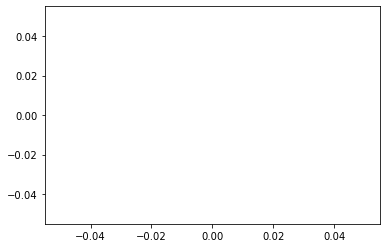

In [18]:
tprs = []
aucs = scores['test_roc_auc']
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()

for idx in range(n_splits):
    fpr = scores['test_fpr']
    tpr = scores['test_tpr']
    
    ax.plot(fpr, tpr, color='b',
        lw=2, alpha=.8)
    
    # interpolate the tpr
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)


In [ ]:
metrics = [
    'roc_auc', 'accuracy', 'balanced_accuracy', 'average_precision', 'precision', 'neg_brier_score',
    '
]
for idx in range(n_splits):
    